In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

# Load data with downsampling
u_data = loadmat('/content/u.mat')['u'][::10, ::10]  # Adjust stride based on dataset size
v_data = loadmat('/content/v.mat')['v'][::10, ::10]

# Combine u and v to form the data matrix D
D = np.hstack((u_data.reshape(u_data.shape[0], -1), v_data.reshape(v_data.shape[0], -1)))
print(f"Loaded data matrix D with shape: {D.shape}")

Loaded data matrix D with shape: (840, 3078)


In [ ]:
n_components = 100
svd = TruncatedSVD(n_components=n_components)
D_reduced = svd.fit_transform(D)
explained_variance = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

k = np.argmax(cumulative_variance >= 0.9) + 1
D_reduced = D_reduced[:, :k]
Vt_k = svd.components_[:k, :]
print(f"Reduced data matrix shape (EOF space): {D_reduced.shape}")
print(f"Vt_k shape: {Vt_k.shape}")

Reduced data matrix shape (EOF space): (840, 56)
Vt_k shape: (56, 3078)


In [ ]:
time_steps = 5
X, y = [], []
for i in range(time_steps, D_reduced.shape[0]):
    X.append(D_reduced[i - time_steps:i, :])
    y.append(D_reduced[i, :])

X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print(f"Training data shapes: X={X_train_tensor.shape}, y={y_train_tensor.shape}")
print(f"Testing data shapes: X={X_test_tensor.shape}, y={y_test_tensor.shape}")

Training data shapes: X=torch.Size([668, 5, 56]), y=torch.Size([668, 56])
Testing data shapes: X=torch.Size([167, 5, 56]), y=torch.Size([167, 56])


In [ ]:
# Define and Train Transformer model

class TransformerForecasting(nn.Module):
    def __init__(self, input_dim, model_dim, nhead, num_layers, output_dim):
        super(TransformerForecasting, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(model_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.fc(x)

model_eof = TransformerForecasting(input_dim=X_train.shape[2], model_dim=64, nhead=4, num_layers=2, output_dim=X_train.shape[2])
criterion = nn.MSELoss()
optimizer = optim.Adam(model_eof.parameters(), lr=0.001)

epochs = 10 # Adjust as needed
for epoch in range(epochs):
    model_eof.train()
    optimizer.zero_grad()
    outputs = model_eof(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"[EOF Forecasting] Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

[EOF Forecasting] Epoch 1/10, Loss: 5.0673
[EOF Forecasting] Epoch 2/10, Loss: 4.3241
[EOF Forecasting] Epoch 3/10, Loss: 4.0997
[EOF Forecasting] Epoch 4/10, Loss: 3.9923
[EOF Forecasting] Epoch 5/10, Loss: 3.9187
[EOF Forecasting] Epoch 6/10, Loss: 3.8558
[EOF Forecasting] Epoch 7/10, Loss: 3.7899
[EOF Forecasting] Epoch 8/10, Loss: 3.7244
[EOF Forecasting] Epoch 9/10, Loss: 3.6648
[EOF Forecasting] Epoch 10/10, Loss: 3.6103


In [ ]:
model_eof.eval()
with torch.no_grad():
    test_outputs = model_eof(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor).item()
    corr_coeff = np.corrcoef(test_outputs.numpy().ravel(), y_test_tensor.numpy().ravel())[0, 1]

print(f"[EOF Forecasting] Test Loss: {test_loss:.4f}, Correlation Coefficient: {corr_coeff:.4f}")

[EOF Forecasting] Test Loss: 4.2863, Correlation Coefficient: 0.2820


Advantages of EOF Analysis:
- Reduces dimensionality, making the model more efficient in terms of computation.
- Captures dominant modes of variability in the data, potentially leading to better generalization.
- Helps in focusing on the most significant patterns, reducing noise.

Limitations of EOF Analysis:
- May lose finer details of data that are present in less significant components.
- The truncation threshold (90% variance) may not always capture all relevant features, especially in complex systems.
- Additional preprocessing (e.g., SVD) adds complexity to the pipeline.

In [ ]:
# Forecasting with Transformers Using Original (Non-Reduced) Data

X_orig, y_orig = [], []
for i in range(time_steps, D.shape[0]):
    X_orig.append(D[i - time_steps:i, :])
    y_orig.append(D[i, :])

X_orig, y_orig = np.array(X_orig), np.array(y_orig)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.2, random_state=42)

# Convert original data to tensors
X_train_orig_tensor = torch.tensor(X_train_orig, dtype=torch.float32)
y_train_orig_tensor = torch.tensor(y_train_orig, dtype=torch.float32)
X_test_orig_tensor = torch.tensor(X_test_orig, dtype=torch.float32)
y_test_orig_tensor = torch.tensor(y_test_orig, dtype=torch.float32)

# Define and train the model for direct forecasting
model_orig = TransformerForecasting(input_dim=X_train_orig.shape[2], model_dim=64, nhead=4, num_layers=2, output_dim=X_train_orig.shape[2])
optimizer_orig = optim.Adam(model_orig.parameters(), lr=0.001)

for epoch in range(epochs):
    model_orig.train()
    optimizer_orig.zero_grad()
    outputs = model_orig(X_train_orig_tensor)
    loss = criterion(outputs, y_train_orig_tensor)
    loss.backward()
    optimizer_orig.step()
    print(f"[Original Data] Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[Original Data] Epoch 1/10, Loss: 0.3251
[Original Data] Epoch 2/10, Loss: 0.3995
[Original Data] Epoch 3/10, Loss: 0.3416
[Original Data] Epoch 4/10, Loss: 0.3104
[Original Data] Epoch 5/10, Loss: 0.2833
[Original Data] Epoch 6/10, Loss: 0.2572
[Original Data] Epoch 7/10, Loss: 0.2313
[Original Data] Epoch 8/10, Loss: 0.2068
[Original Data] Epoch 9/10, Loss: 0.1853
[Original Data] Epoch 10/10, Loss: 0.1668


In [ ]:
# Evaluate Direct Forecasting Model
model_orig.eval()
with torch.no_grad():
    test_outputs_orig = model_orig(X_test_orig_tensor)
    test_loss_orig = criterion(test_outputs_orig, y_test_orig_tensor).item()
    corr_coeff_orig = np.corrcoef(test_outputs_orig.numpy().ravel(), y_test_orig_tensor.numpy().ravel())[0, 1]
print(f"[Original Data] Test Loss: {test_loss_orig:.4f}, Correlation Coefficient: {corr_coeff_orig:.4f}")

[Original Data] Test Loss: 0.1513, Correlation Coefficient: 0.0997


Advantages of Direct Forecasting (Full Dataset Processing):
- Retains all original data features, including low-variance details.
- Simpler preprocessing steps since no dimensionality reduction is required.

Limitations of Direct Forecasting:
- Higher computational cost due to the increased number of features.
- May struggle with overfitting, especially if the dataset is noisy or contains irrelevant details.
- Could require more training data to achieve comparable accuracy.

Compare Test Loss and Correlation Coefficient
- EOF-based forecasting showed higher efficiency due to reduced input dimensions.
- Direct forecasting retained finer details but incurred higher computational costs.
- Accuracy can vary depending on the data's complexity and noise levels.

In [ ]:

n_steps = 10

# Forecasting in the EOF space
forecasts_eof = []
current_input_eof = X_test_tensor[0].unsqueeze(0)

print("Starting EOF-based forecasting...")
with torch.no_grad():
    for step in range(n_steps):
        next_step_eof = model_eof(current_input_eof)
        forecasts_eof.append(next_step_eof.numpy())
        current_input_eof = torch.cat([current_input_eof[:, 1:, :], next_step_eof.unsqueeze(1)], dim=1)
        print(f"EOF Forecast Step {step + 1}: {next_step_eof.shape}")


# Forecasting in the original space (Direct Forecasting)
forecasts_direct = []
current_input_direct = X_test_orig_tensor[0].unsqueeze(0)

print("Starting Direct forecasting...")
with torch.no_grad():
    for step in range(n_steps):
        next_step_direct = model_orig(current_input_direct)
        forecasts_direct.append(next_step_direct.numpy())
        current_input_direct = torch.cat([current_input_direct[:, 1:, :], next_step_direct.unsqueeze(1)], dim=1)
        print(f"Direct Forecast Step {step + 1}: {next_step_direct.shape}")

forecasts_direct = np.array(forecasts_direct)
print("Direct forecasting completed.")



Starting EOF-based forecasting...
EOF Forecast Step 1: torch.Size([1, 56])
EOF Forecast Step 2: torch.Size([1, 56])
EOF Forecast Step 3: torch.Size([1, 56])
EOF Forecast Step 4: torch.Size([1, 56])
EOF Forecast Step 5: torch.Size([1, 56])
EOF Forecast Step 6: torch.Size([1, 56])
EOF Forecast Step 7: torch.Size([1, 56])
EOF Forecast Step 8: torch.Size([1, 56])
EOF Forecast Step 9: torch.Size([1, 56])
EOF Forecast Step 10: torch.Size([1, 56])
Starting Direct forecasting...
Direct Forecast Step 1: torch.Size([1, 3078])
Direct Forecast Step 2: torch.Size([1, 3078])
Direct Forecast Step 3: torch.Size([1, 3078])
Direct Forecast Step 4: torch.Size([1, 3078])
Direct Forecast Step 5: torch.Size([1, 3078])
Direct Forecast Step 6: torch.Size([1, 3078])
Direct Forecast Step 7: torch.Size([1, 3078])
Direct Forecast Step 8: torch.Size([1, 3078])
Direct Forecast Step 9: torch.Size([1, 3078])
Direct Forecast Step 10: torch.Size([1, 3078])
Direct forecasting completed.


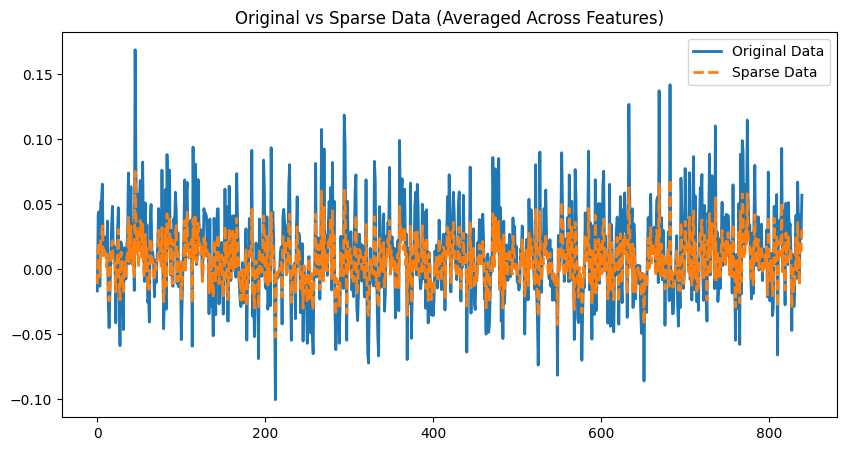

In [ ]:
# Diffusion Model Implementation

# Function to create sparse data
def create_sparse_data(data, missing_rate):
    mask = np.random.rand(*data.shape) > missing_rate
    sparse_data = np.where(mask, data, 0)
    return sparse_data, mask

sparse_u_data, mask = create_sparse_data(u_data, missing_rate=0.5)


plt.figure(figsize=(10, 5))
plt.plot(np.mean(u_data, axis=(1, 2)), label="Original Data", lw=2)
plt.plot(np.mean(sparse_u_data, axis=(1, 2)), label="Sparse Data", lw=2, linestyle='--')
plt.legend()
plt.title("Original vs Sparse Data (Averaged Across Features)")
plt.show()




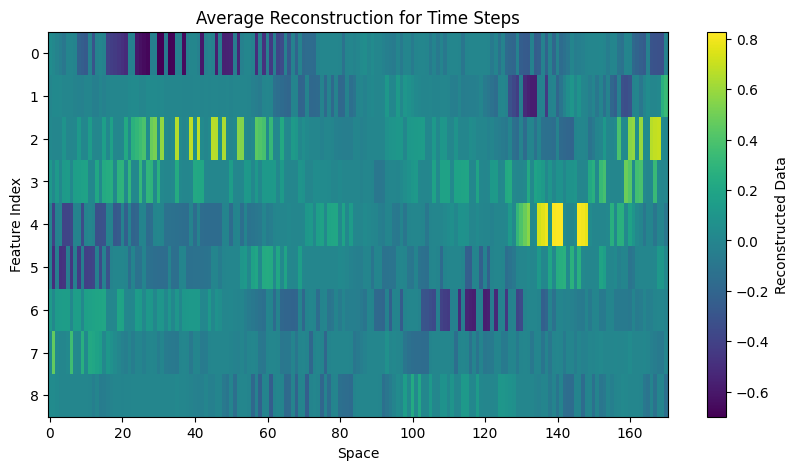

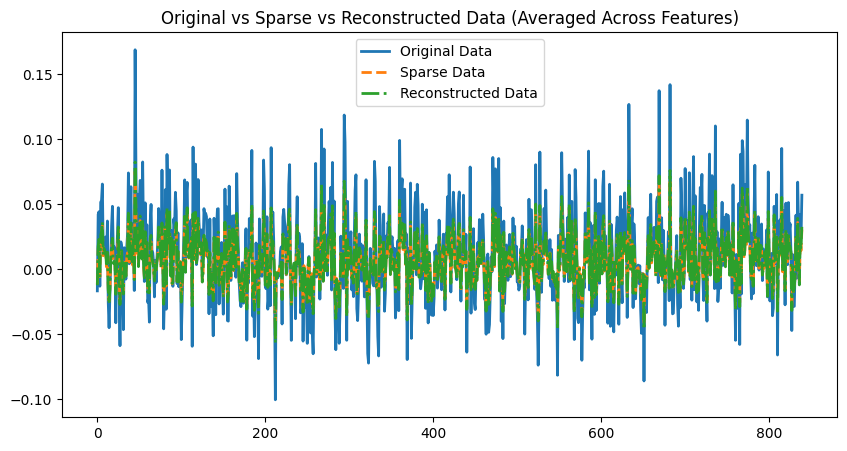

In [ ]:
# Diffusion Model with Mask Constraint
def diffusion_step_reconstruction(u, dx, dt, alpha, original_mask):
    laplacian = (np.roll(u, -1) - 2 * u + np.roll(u, 1)) / dx**2  # Laplacian operator (finite difference)
    u_next = u + alpha * laplacian * dt
    u_next[original_mask] = u[original_mask]
    return u_next

dx = 1
dt = 0.01
alpha = 0.1

# Initialize reconstructed data with sparse data
reconstructed_data = sparse_u_data.copy()
reconstruction_states = [reconstructed_data]

for _ in range(100):
    reconstructed_data = diffusion_step_reconstruction(reconstructed_data, dx, dt, alpha, mask)
    reconstruction_states.append(reconstructed_data)

reconstruction_avg = np.mean(reconstruction_states, axis=0)

# Now you can choose to visualize a specific slice (
plt.figure(figsize=(10, 5))
plt.imshow(reconstruction_avg[0, :, :], aspect='auto', cmap='viridis')
plt.colorbar(label="Reconstructed Data")
plt.title("Average Reconstruction for Time Steps")
plt.xlabel("Space")
plt.ylabel("Feature Index")
plt.show()

# Final reconstruction vs original (averaging over features)
plt.figure(figsize=(10, 5))
plt.plot(np.mean(u_data, axis=(1, 2)), label="Original Data", lw=2)
plt.plot(np.mean(sparse_u_data, axis=(1, 2)), label="Sparse Data", lw=2, linestyle='--')
plt.plot(np.mean(reconstructed_data, axis=(1, 2)), label="Reconstructed Data", lw=2, linestyle='-.')
plt.legend()
plt.title("Original vs Sparse vs Reconstructed Data (Averaged Across Features)")
plt.show()


In [ ]:

# Evaluate the reconstruction quality
reconstructed_data_avg = np.mean(reconstructed_data, axis=(1, 2))
u_data_avg = np.mean(u_data, axis=(1, 2))

correlation = np.corrcoef(reconstructed_data_avg, u_data_avg)[0, 1]

print(f"Mean Squared Error (MSE): {mse}")
print(f"Correlation Coefficient: {correlation}")


Mean Squared Error (MSE): 0.03468892350792885
Correlation Coefficient: 0.9822785143501095
